In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [182]:
def lambda_initaliser(n): #bigger Lambda means smaller effective updates, more regularisation, more precise prior
#     return (np.ones((n,n))+np.eye(n))*1e1
#     return (-1*np.ones((n,n))+np.eye(n)*(n))*1
#     return (np.ones((n,n))+np.diag(np.random.rand(n))+np.random.rand(n,n)*0.1)*1
    return (np.eye(n))/n**1#/np.sqrt(n)
#     return np.ones((n,n))*1e-4

In [195]:
def initialiser_function(rows,columns):
#     return np.random.randn(rows,columns)
#     inits= np.zeros((rows,columns))+np.random.randn(rows,columns)*0.1
    inits=(np.random.randn(rows,columns))*np.sqrt(6)/np.sqrt(rows+columns)

#     inits=(np.random.randn(rows,columns)*2)*np.sqrt(6)/np.sqrt(rows+columns)*0
#     inits=(np.random.randn(rows,columns))*0.1#*np.sqrt(6)/np.sqrt(rows+columns)
#     inits=(np.random.rand(rows,columns)*2-1)*np.sqrt(6)/np.sqrt(rows+columns)

#     inits[0,:]=np.ones((1,columns))
    return inits


In [7]:
def bias_initialiser(n):

    return (np.random.randn(1,n)*2-1)*np.sqrt(6)/np.sqrt(n+1)


In [140]:
class NNet:
    # this is a standard normal network using ReLU activation functions
    # and an identity as the output activation function
    # it is trained using standard gradient descent with gradients calculated using backprop
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function):
        
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        
        self.weights=[] #initialise weights, the bias vectors are treated as an extra row of the weights
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        
        #initialise variables calculated when using the network
        self.activated=[] 
        self.z=[]
        self.a=[]
        self.Delta=[]
        
    def forward(self,x):
        # Does a forward pass of the network, and saves relevent variables
        
        #clear saved variables for forward pass
        self.z=[]
        self.a=[]
        self.activated=[]
        
        x=np.hstack([np.ones((x.shape[0],1)),x]) #append 1 to the x to account for the bias

        for ii in range(len(self.weights)):

            x=x @ self.weights[ii]

            if not ii== len(self.weights)-1: #if not the end
                x=np.hstack([np.ones((x.shape[0],1)),x]) # append 1 to account for the bias
                self.activated.append(x>0) #save whether the neurons were activated
                self.z.append(x) 
                x=x*self.activated[ii] #apply ReLU activation function
                self.a.append(x) #save activations

                if np.sum(np.sum(self.activated[ii]))==0: #if there are no activations in a layer
                    print('No activations')
            
        self.z.append(x) #append the final things
        
        # for this case we are using the identity as the final activation function because we want to 
        # approximate functions with negative values
        # this means that the neurons in the final layer are always activated
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
        return x
    
    def gradients(self,x,Y):
        # calculates the gradients of neural network using standard back propagation
        
        Delta=[] #Delta=d(loss)/dz=d(loss)/da*gradsigma(z)
        
        #the self.activated variable is the effectively the grad of the activation function

        Delta.append((Y-self.a[-1])*self.activated[-1]) #calculate Delta for the final layer
        for ll in range(len(self.weights)-2,-1,-1):
            #calculate Delta for the other layers
            Delta.insert(0,((Delta[0] @ self.weights[ll+1].T)*self.activated[ll])[:,1:])
        
        grad_w=[] #calculating the gradient of the error with respect to the weights
        grad_w.append(Delta[0].T @ np.hstack([np.ones((x.shape[0],1)),x]))
        for ll in range(len(Delta)-1):
            grad_w.append(Delta[ll+1].T @ self.a[ll])
            
        return grad_w
    
    def train(self,xx,YY,alpha=0.01, print_error=False):
        #trains the neural network for one epoch, one sample at a time using standard SGD
        
        #shuffle the data
        inds=np.arange(xx.shape[0])
        np.random.shuffle(inds)
        xx=xx[inds,:]
        YY=YY[inds,:]
        
        for ii in range(len(YY)):
            # for each piece of data
            x=xx[ii,:]
            x=x.reshape((1,x.shape[0]))
            Y=YY[ii,:]
            
            Y_out=self.forward(x) #do a forward pass
            error_out=np.sum((Y-Y_out)**2) #calcuate the loss, in this case the square error
            grad_w=self.gradients(x,Y) #calculate the gradients
#             print(self.biases)
            for ll in range(len(self.weights)):
                # update the weights using the gradients
                self.weights[ll]=self.weights[ll]+alpha*grad_w[ll].T
                
            if print_error: #print the error if you want
                print(str(ii)+': Error: '+ str(error_out))
            

In [9]:
class BNet5:
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function,lambda_initaliser=lambda_initaliser):
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.weights=[]
        self.biases=[]
        self.Lambda=[]
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        self.Lambda.append(lambda_initaliser(input_dim+1))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
            self.Lambda.append(lambda_initaliser(hidden_layer_sizes[ii]+1))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        self.Lambda.append(lambda_initaliser(hidden_layer_sizes[-1]+1))
        self.activated=[]
        self.z=[]
        self.a=[]
        self.Delta=[]
    def forward(self,x):
#         print(x.shape)
        self.z=[]
        self.a=[]
        self.activated=[]
#         assert len(x)==self.input_dim
        x=np.hstack([np.ones((x.shape[0],1)),x])
        all_activated=1
        for ii in range(len(self.weights)):

            x=x @ self.weights[ii]

#             self.activated.append(x>0)
#             self.z.append(x)
            if not ii== len(self.weights)-1:
                x=np.hstack([np.ones((x.shape[0],1)),x])
                self.activated.append(x>0)
                self.z.append(x)
                x=x*self.activated[ii]
                self.a.append(x)
#             print(x)
                if np.sum(np.sum(self.activated[ii][:,1:]))==0:
#                     print('No activations')
                    all_activated=0
        self.z.append(x)
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
#             print(self.activated)
        return x, all_activated
    
    
    
    def train(self,xx,YY,passes=1, print_error=False,attempt_numbers=5,total_info=1):
        c=total_info/passes
        sample_used=np.zeros(len(xx))
        for attempt in range(attempt_numbers):
            
            for ii in range(len(YY)):
                
                if not sample_used[ii]:
                    x=xx[ii]
                    x=x.reshape((1,x.shape[0]))
                    Y=YY[ii]
                    Y=Y.reshape((1,Y.shape[0]))
        #             print(Y.shape)
                    Y_out,all_activated=self.forward(x)
#                     all_activated=1
                    error_out1=np.sum((Y-Y_out)**2)
                    if all_activated:
                        sample_used[ii]=1

                        for ps in range(passes):
                            Y_out,all_activated=self.forward(x)

                            for ll in range(len(self.weights)-1,-1,-1):
            #                     print(ll)
                                xl=self.a[ll-1]
                                if ll==len(self.weights)-1:
                                    Yl=Y
                                    w=self.weights[ll]
                                else:
            #                         print(Yl.shape)
            # #                         print(np.linalg.pinv(self.weights[ll+1]).shape)
            #                         print(np.linalg.pinv(w).shape)

                                    Yl=Yl @ np.linalg.pinv(w)
                                    Yl=Yl[:,1:]/Yl[0,0] #the bias isn't an outout of the previous transformation, but we can use it to normalise
            #                         print(Yl.shape)
                                    Yl=Yl[:,self.activated[ll][0,1:]]
                                    w=self.weights[ll][:,self.activated[ll][0,1:]] #this constructs a new weight mat using only the columns that lead to activations
                                L=self.Lambda[ll]

            #                     print(xl.T.shape)
            #                     print(Yl.shape)
            #                     print(L.shape)
            #                     print(w.shape)
            #                     print(w)
            #                     print(w.shape)
            #                     print(Yl.shape)

            #                     print(xl.shape)
            #                     print(w.shape)
            #                     print(np.linalg.inv(c*(xl.T @ xl) + L).shape)
            #                     print(((xl.T @ Yl)).shape)
            #                     print(L.shape)
                                w=np.linalg.pinv(c*(xl.T @ xl) + L) @ (c*(xl.T @ Yl) + L @ w)
            #                     print(w)
                                w=np.nan_to_num(w)
                                L=c*xl.T @ xl + L
                                if ll==len(self.weights)-1:
                                    self.weights[ll]=w
                                else:
                                    self.weights[ll][:,self.activated[ll][0,1:]]=w
                                self.Lambda[ll]=L
            #                     print(self.weights[ll])
                    else:
                        print('not today')
                    Y_out,all_activated=self.forward(x)

                    error_out2=np.sum((Y-Y_out)**2)

                    if print_error:
                        print(str(ii)+': Error1: '+ str(error_out1)+', Error2: '+ str(error_out2))
            print(sum(sample_used))

In [142]:
def find_Y(Y,w1,X0): 
    # This function finds the new Y value for the layer, by going 'backwards' through the matrix
    # initally we had X0 @ w0 = Y, and then updated w0 -> w1, so now we solve X1 @ w1 = Y for X1
    # this is often under determined, and so we find the X1 which is closest (L2 norm) to X0

    delta=w1 @ np.linalg.inv(w1.T @ w1) @ (Y - X0 @ w1).T
    X1 = X0+delta.T

    # remember to kill bias if needed
    return X1

In [243]:
class BNet6:
    # Neural net that can be trained using approximate (dodgy) Bayesian updating
    # The forward pass works just like a standard neural net
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function,lambda_initaliser=lambda_initaliser):
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        
        # initalise the weights and Lambda matrices
        # the weights are the standard weights of the network
        # the Lambda matrices are the (inverse of) the covariance matrices of the rows of the weight matrices
        # the Lambdas are a measure of the 'precision' of each weight matrix
        # we do not consider any effect of covariance between different layers (that's a task for another day...)
        self.weights=[]
        self.Lambda=[]
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        self.Lambda.append(lambda_initaliser(input_dim+1))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
            self.Lambda.append(lambda_initaliser(hidden_layer_sizes[ii]+1))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        self.Lambda.append(lambda_initaliser(hidden_layer_sizes[-1]+1))
        
        #initialise variables calculated when using the network
        self.activated=[]
        self.z=[]
        self.a=[]
        self.Delta=[]
    def forward(self,x):
        #performs a standard forward pass of the network, saving relevant variables
        
        self.z=[]
        self.a=[]
        self.activated=[]
        x=np.hstack([np.ones((x.shape[0],1)),x]) #append 1 to account for bias
        all_activated=1 #keep to make sure there is at least one activation in each layer
        # if there are no activations in a layer then you can't do the back step
        # Not sure if the bias should count towards the activation (I don't think so)
        
        for ii in range(len(self.weights)):

            x=x @ self.weights[ii] #apply weight matrix

            if not ii== len(self.weights)-1: # if it's not the final layer
                
                x=np.hstack([np.ones((x.shape[0],1)),x]) #append the 1 for the bias
                self.activated.append(x>0) #which neurons are activated
                self.z.append(x)
                x=x*self.activated[ii] #apply the ReLU
                self.a.append(x) #save activations
#             print(x)
                if np.sum(np.sum(self.activated[ii][:,1:]))==0: #test if there was at least on activation in each layer
#                     print('No activations')
                    all_activated=0
        #saving variables for the last layer
        #for this output layer we are using just the identity as the activation function (not a non linear function)
        # this can be thought of as a ReLU that is always activated
        self.z.append(x)
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
        return x, all_activated
    
    
    
    def train(self,xx,YY,passes=1, print_error=False,failed_attempts=5,total_info=1):
        # trains the network using 'Bayes'
        # xx is the input data, YY measured variable corresponding to xx
        # passes is the number of times you go over the data
        # total_info is the total amount of 'information' transfered over all the passes
        # print_error if you want to print the error each time
        # failed_attempts is how many times to try use the same piece of data if each time it
        # means that there are no neurons in a layer and thus can't be used to train
        
        #shuffle the data
        inds=np.arange(xx.shape[0])
        np.random.shuffle(inds)
        xx=xx[inds,:]
        YY=YY[inds,:]
        
        c=total_info/passes #this is analogous to alpha in SGD
        sample_used=np.zeros(len(xx)) # number of times the sample has been used, corresponds to 'passes'
        sample_attempted= np.zeros(len(xx)) # number of times the sample has been attempted and failed, corresponds to 'failed_attempts'
        
        
        still_going= True # keeps going if we haven't had the right number of passes or failed attempts
        
        while still_going:
            
            for ii in range(len(YY)): #for each sample

                if sample_used[ii]<passes: #if this data hasn't already been used 
                    x=xx[ii,:]
#                     print(x)
                    x=x.reshape((1,x.shape[0]))
#                     print(x)
                    
                    Y=YY[ii,:]
                    Y=Y.reshape((1,Y.shape[0]))
#                     print(Y.shape)
                    Y_out,all_activated=self.forward(x)
    #                     all_activated=1
                    
                    error_out1=np.sum((Y-Y_out)**2)
                    if all_activated:
                        sample_used[ii]+=1

                        for ps in range(passes):
                            Y_out,all_activated=self.forward(x)

                            for ll in range(len(self.weights)-1,-1,-1):
            #                     print(ll)
                                xl=self.a[ll-1]
                                if ll==len(self.weights)-1:
                                    Yl=Y
                                    w=self.weights[ll]
                                else:
            #                         print(Yl.shape)
            # #                         print(np.linalg.pinv(self.weights[ll+1]).shape)
            #                         print(np.linalg.pinv(w).shape)

#                                     Yl=Yl @ np.linalg.pinv(w)
#                                     Yl=Yl[:,1:]/Yl[0,0] #the bias isn't an outout of the previous transformation, but we can use it to normalise
            #                         print(Yl.shape)
#                                     Yl=find_Y(Yl,w[1:,:],self.a[ll][:,1:])
                                    
                                    Yl= find_Y(Yl, w, self.a[ll])
                                    Yl=Yl[:,1:]/Yl[0,0]
    
                                    Yl=Yl[:,self.activated[ll][0,1:]]
                
                                    w=self.weights[ll][:,self.activated[ll][0,1:]] #this constructs a new weight mat using only the columns that lead to activations
                                L=self.Lambda[ll]

            #                     print(xl.T.shape)
            #                     print(Yl.shape)
            #                     print(L.shape)
            #                     print(w.shape)
            #                     print(w)
            #                     print(w.shape)
#                                 print('Yl')
#                                 print(Yl.shape)
#                                 print('xl')
#                                 print(xl.shape)
#                                 print('w')
#                                 print(w.shape)
            #                     print(np.linalg.inv(c*(xl.T @ xl) + L).shape)
            #                     print(((xl.T @ Yl)).shape)
#                                 print('L')
#                                 print(L.shape)
                                w=np.linalg.inv(c*(xl.T @ xl) + L) @ (c*(xl.T @ Yl) + L @ w)
            #                     print(w)
                                w=np.nan_to_num(w)
                                L=c*xl.T @ xl + L
#                                 L=L*np.eye(L.shape[0])
                                if ll==len(self.weights)-1:
                                    self.weights[ll]=w
                                else:
                                    self.weights[ll][:,self.activated[ll][0,1:]]=w
                                self.Lambda[ll]=L
            #                     print(self.weights[ll])
                    else:
                        print('not today')
                        sample_attempted[ii]+=1
                    Y_out,all_activated=self.forward(x)

                    error_out2=np.sum((Y-Y_out)**2)

                    if print_error:
                        print(str(ii)+': Error1: '+ str(error_out1)+', Error2: '+ str(error_out2), end="\r", flush=True)
            print(sum(sample_used))
#             print(sample_used)
#             print(sample_attempted)
            print(sum([((sample_used[jj]>=passes) or (sample_attempted[jj]>= failed_attempts)) for jj in range(len(YY))]))
            if all([(sample_used[jj]>=passes or sample_attempted[jj]>= failed_attempts) for jj in range(len(YY))]):
                still_going=False

not today
not today
not today
not today
not today
not today
not today
94.0
101
101.0
101
101.0
101


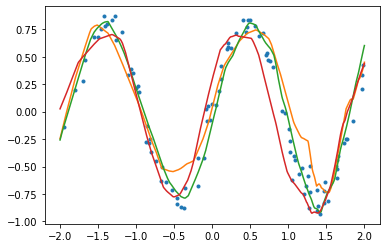

In [237]:

n_data=101
# hidden_layers=[16,32,256,32,16]
hidden_layers=[128,128,256,128]
x=np.random.rand(n_data,1)*4-2
y= 0.8*np.sin(x*3.4)+np.random.randn(x.shape[0],x.shape[1])*0.1
x_test=np.linspace(-2,2,1000).reshape(1000,1)
plt.plot(x,y,'.')
for ii in range(3):
    net=BNet6(hidden_layer_sizes=hidden_layers,input_dim=1,output_dim=1,lambda_initaliser=lambda_initaliser,initialiser_function=initialiser_function)
    net.train(x,y,print_error=False,passes=1,total_info=1,failed_attempts=1)
    plt.plot(x_test,net.forward(x_test)[0])

In [233]:
y.shape,x.shape

((101, 1), (101, 1))

In [462]:
np.random.randn(3,1)

array([[-0.02357909],
       [-0.61785435],
       [ 1.9961463 ]])

In [238]:
def test_fun_2d(x):
    y=0.8*np.cos(np.sqrt(x[:,0]**2+x[:,1]**2)*5)
#     y=0.8*np.cos(x[:,0]*5)

    y=y.reshape((y.shape[0],1))+np.random.randn(y.shape[0],1)*0.1

    return y

In [229]:
aa=np.random.randn(3,4)
np.eye(aa.shape)

TypeError: 'tuple' object cannot be interpreted as an integer

In [241]:

n_data=1001
# hidden_layers=[16,32,256,32,16]
hidden_layers=[16,16,16,16]
hidden_layers=[128,128,128]
hidden_layers=[32,256,256,32]
n1=int(np.sqrt(n_data))
# x1,x2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
# x=np.hstack([x1.reshape((n1*n1,1)),x2.reshape(n1*n1,1)])
x=np.random.rand(n_data,2)*4-2
# y= 0.8*np.sin(x[:,0]*3.4)+0.8*np.sin(x[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
# y=y.reshape((y.shape[0],1))
y=test_fun_2d(x)
x_test=np.linspace(-2,2,1000).reshape(1000,1)
# plt.plot(x,y,'.')
for ii in range(1):
    net=BNet6(hidden_layer_sizes=hidden_layers,input_dim=2,output_dim=1,lambda_initaliser=lambda_initaliser,initialiser_function=initialiser_function)
    net.train(x,y,print_error=True,passes=1,total_info=1,failed_attempts=10)
#     plt.plot(x_test,net.forward(x_test)[0])

1001.0Error1: 0.0008610428913830399, Error2: 0.00062645197342301745
1001


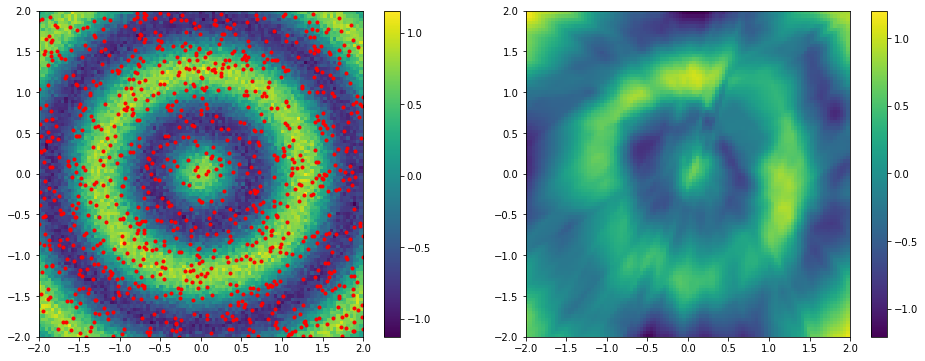

In [242]:
n1=100
x_test1,x_test2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x_test_2d=np.hstack([x_test1.reshape((n1*n1,1)),x_test2.reshape(n1*n1,1)])
y_test_net_2d=net.forward(x_test_2d)[0].reshape((n1,n1))
# y_test_2d= 0.8*np.sin(x_test_2d[:,0]*3.4)+0.8*np.sin(x_test_2d[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
y_test_2d=test_fun_2d(x_test_2d)
y_test_2d=y_test_2d.reshape((n1,n1))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pcolor(x_test1,x_test2,y_test_2d);
plt.colorbar()
plt.plot(x[:,0],x[:,1],'r.')
plt.subplot(1,2,2)
plt.pcolor(x_test1,x_test2,y_test_net_2d);
plt.colorbar()
# plt.plot(x[:,0],x[:,1],'r.')



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


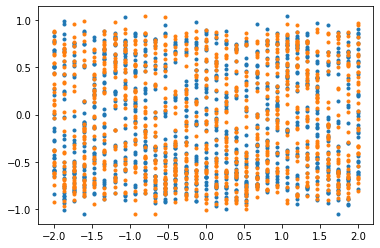

In [146]:

n_data=1001
# hidden_layers=[16,32,256,32,16]
hidden_layers=[16,16,16,16]
# hidden_layers=[64,128,128,64]
hidden_layers=[32,32,32,32]
n1=int(np.sqrt(n_data))
x1,x2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x=np.hstack([x1.reshape((n1*n1,1)),x2.reshape(n1*n1,1)])
# x=np.random.rand(n_data,2)*4-2
# y= 0.8*np.sin(x[:,0]*3.4)+0.8*np.sin(x[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
# y=y.reshape((y.shape[0],1))
y=test_fun_2d(x)
x_test=np.linspace(-2,2,1000).reshape(1000,1)
plt.plot(x,y,'.')
nnet=NNet(hidden_layer_sizes=hidden_layers,input_dim=2,output_dim=1,initialiser_function=initialiser_function2)

for ii in range(50):
    print(ii)
    nnet.train(x,y,print_error=False,alpha=0.01)
#     plt.plot(x_test,net.forward(x_test)[0])

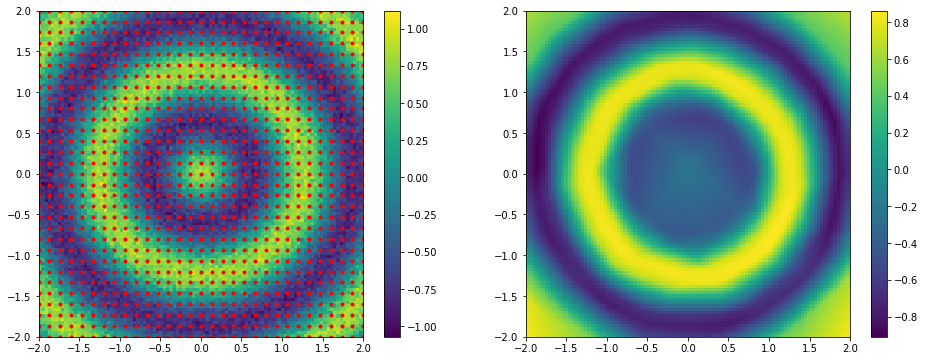

In [147]:
n1=100
x_test1,x_test2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x_test_2d=np.hstack([x_test1.reshape((n1*n1,1)),x_test2.reshape(n1*n1,1)])
y_test_net_2d=nnet.forward(x_test_2d).reshape((n1,n1))
# print(y_test_net_2d.shape)
# y_test_2d= 0.8*np.sin(x_test_2d[:,0]*3.4)+0.8*np.sin(x_test_2d[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
y_test_2d=test_fun_2d(x_test_2d)
y_test_2d=y_test_2d.reshape((n1,n1))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pcolor(x_test1,x_test2,y_test_2d);
plt.colorbar()
plt.plot(x[:,0],x[:,1],'r.')
plt.subplot(1,2,2)
plt.pcolor(x_test1,x_test2,y_test_net_2d);
plt.colorbar()
# plt.plot(x[:,0],x[:,1],'r.')


In [843]:
n_data=10001
x=np.random.rand(n_data,1)*4-2
y= 0.8*np.sin(x*3.4)+np.random.randn(x.shape[0],x.shape[1])*0.1
net=NNet2(hidden_layer_sizes=[16,32,64],input_dim=1,output_dim=1,initialiser_function=initialiser_function2)
net.train(x,y,print_error=True)

0: Error: 334.35268309062906
1: Error: 554797.848962102
2: Error: 314101399663.7126
3: Error: 2.692941677171469e+51
4: Error: 1.4828564323933328e+202
5: Error: inf
6: Error: nan
7: Error: nan
8: Error: nan
9: Error: nan
10: Error: nan
11: Error: nan
12: Error: nan
13: Error: nan
14: Error: nan
15: Error: nan
16: Error: nan
17: Error: nan
18: Error: nan
19: Error: nan
20: Error: nan
21: Error: nan
22: Error: nan
23: Error: nan
24: Error: nan
25: Error: nan
26: Error: nan
27: Error: nan
28: Error: nan
29: Error: nan
30: Error: nan
31: Error: nan
32: Error: nan
33: Error: nan
34: Error: nan
35: Error: nan
36: Error: nan
37: Error: nan
38: Error: nan
39: Error: nan
40: Error: nan
41: Error: nan
42: Error: nan
43: Error: nan
44: Error: nan
45: Error: nan
46: Error: nan
47: Error: nan
48: Error: nan
49: Error: nan
50: Error: nan
51: Error: nan
52: Error: nan
53: Error: nan
54: Error: nan
55: Error: nan
56: Error: nan
57: Error: nan
58: Error: nan
59: Error: nan
60: Error: nan
61: Error: nan


/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in matmul
/usr/lib/python3/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in matmul
/usr/lib/python3/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in matmul
/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


239: Error: nan
240: Error: nan
241: Error: nan
242: Error: nan
243: Error: nan
244: Error: nan
245: Error: nan
246: Error: nan
247: Error: nan
248: Error: nan
249: Error: nan
250: Error: nan
251: Error: nan
252: Error: nan
253: Error: nan
254: Error: nan
255: Error: nan
256: Error: nan
257: Error: nan
258: Error: nan
259: Error: nan
260: Error: nan
261: Error: nan
262: Error: nan
263: Error: nan
264: Error: nan
265: Error: nan
266: Error: nan
267: Error: nan
268: Error: nan
269: Error: nan
270: Error: nan
271: Error: nan
272: Error: nan
273: Error: nan
274: Error: nan
275: Error: nan
276: Error: nan
277: Error: nan
278: Error: nan
279: Error: nan
280: Error: nan
281: Error: nan
282: Error: nan
283: Error: nan
284: Error: nan
285: Error: nan
286: Error: nan
287: Error: nan
288: Error: nan
289: Error: nan
290: Error: nan
291: Error: nan
292: Error: nan
293: Error: nan
294: Error: nan
295: Error: nan
296: Error: nan
297: Error: nan
298: Error: nan
299: Error: nan
300: Error: nan
301: Err

1277: Error: nan
1278: Error: nan
1279: Error: nan
1280: Error: nan
1281: Error: nan
1282: Error: nan
1283: Error: nan
1284: Error: nan
1285: Error: nan
1286: Error: nan
1287: Error: nan
1288: Error: nan
1289: Error: nan
1290: Error: nan
1291: Error: nan
1292: Error: nan
1293: Error: nan
1294: Error: nan
1295: Error: nan
1296: Error: nan
1297: Error: nan
1298: Error: nan
1299: Error: nan
1300: Error: nan
1301: Error: nan
1302: Error: nan
1303: Error: nan
1304: Error: nan
1305: Error: nan
1306: Error: nan
1307: Error: nan
1308: Error: nan
1309: Error: nan
1310: Error: nan
1311: Error: nan
1312: Error: nan
1313: Error: nan
1314: Error: nan
1315: Error: nan
1316: Error: nan
1317: Error: nan
1318: Error: nan
1319: Error: nan
1320: Error: nan
1321: Error: nan
1322: Error: nan
1323: Error: nan
1324: Error: nan
1325: Error: nan
1326: Error: nan
1327: Error: nan
1328: Error: nan
1329: Error: nan
1330: Error: nan
1331: Error: nan
1332: Error: nan
1333: Error: nan
1334: Error: nan
1335: Error: n

2099: Error: nan
2100: Error: nan
2101: Error: nan
2102: Error: nan
2103: Error: nan
2104: Error: nan
2105: Error: nan
2106: Error: nan
2107: Error: nan
2108: Error: nan
2109: Error: nan
2110: Error: nan
2111: Error: nan
2112: Error: nan
2113: Error: nan
2114: Error: nan
2115: Error: nan
2116: Error: nan
2117: Error: nan
2118: Error: nan
2119: Error: nan
2120: Error: nan
2121: Error: nan
2122: Error: nan
2123: Error: nan
2124: Error: nan
2125: Error: nan
2126: Error: nan
2127: Error: nan
2128: Error: nan
2129: Error: nan
2130: Error: nan
2131: Error: nan
2132: Error: nan
2133: Error: nan
2134: Error: nan
2135: Error: nan
2136: Error: nan
2137: Error: nan
2138: Error: nan
2139: Error: nan
2140: Error: nan
2141: Error: nan
2142: Error: nan
2143: Error: nan
2144: Error: nan
2145: Error: nan
2146: Error: nan
2147: Error: nan
2148: Error: nan
2149: Error: nan
2150: Error: nan
2151: Error: nan
2152: Error: nan
2153: Error: nan
2154: Error: nan
2155: Error: nan
2156: Error: nan
2157: Error: n

3012: Error: nan
3013: Error: nan
3014: Error: nan
3015: Error: nan
3016: Error: nan
3017: Error: nan
3018: Error: nan
3019: Error: nan
3020: Error: nan
3021: Error: nan
3022: Error: nan
3023: Error: nan
3024: Error: nan
3025: Error: nan
3026: Error: nan
3027: Error: nan
3028: Error: nan
3029: Error: nan
3030: Error: nan
3031: Error: nan
3032: Error: nan
3033: Error: nan
3034: Error: nan
3035: Error: nan
3036: Error: nan
3037: Error: nan
3038: Error: nan
3039: Error: nan
3040: Error: nan
3041: Error: nan
3042: Error: nan
3043: Error: nan
3044: Error: nan
3045: Error: nan
3046: Error: nan
3047: Error: nan
3048: Error: nan
3049: Error: nan
3050: Error: nan
3051: Error: nan
3052: Error: nan
3053: Error: nan
3054: Error: nan
3055: Error: nan
3056: Error: nan
3057: Error: nan
3058: Error: nan
3059: Error: nan
3060: Error: nan
3061: Error: nan
3062: Error: nan
3063: Error: nan
3064: Error: nan
3065: Error: nan
3066: Error: nan
3067: Error: nan
3068: Error: nan
3069: Error: nan
3070: Error: n

4011: Error: nan
4012: Error: nan
4013: Error: nan
4014: Error: nan
4015: Error: nan
4016: Error: nan
4017: Error: nan
4018: Error: nan
4019: Error: nan
4020: Error: nan
4021: Error: nan
4022: Error: nan
4023: Error: nan
4024: Error: nan
4025: Error: nan
4026: Error: nan
4027: Error: nan
4028: Error: nan
4029: Error: nan
4030: Error: nan
4031: Error: nan
4032: Error: nan
4033: Error: nan
4034: Error: nan
4035: Error: nan
4036: Error: nan
4037: Error: nan
4038: Error: nan
4039: Error: nan
4040: Error: nan
4041: Error: nan
4042: Error: nan
4043: Error: nan
4044: Error: nan
4045: Error: nan
4046: Error: nan
4047: Error: nan
4048: Error: nan
4049: Error: nan
4050: Error: nan
4051: Error: nan
4052: Error: nan
4053: Error: nan
4054: Error: nan
4055: Error: nan
4056: Error: nan
4057: Error: nan
4058: Error: nan
4059: Error: nan
4060: Error: nan
4061: Error: nan
4062: Error: nan
4063: Error: nan
4064: Error: nan
4065: Error: nan
4066: Error: nan
4067: Error: nan
4068: Error: nan
4069: Error: n

4560: Error: nan
4561: Error: nan
4562: Error: nan
4563: Error: nan
4564: Error: nan
4565: Error: nan
4566: Error: nan
4567: Error: nan
4568: Error: nan
4569: Error: nan
4570: Error: nan
4571: Error: nan
4572: Error: nan
4573: Error: nan
4574: Error: nan
4575: Error: nan
4576: Error: nan
4577: Error: nan
4578: Error: nan
4579: Error: nan
4580: Error: nan
4581: Error: nan
4582: Error: nan
4583: Error: nan
4584: Error: nan
4585: Error: nan
4586: Error: nan
4587: Error: nan
4588: Error: nan
4589: Error: nan
4590: Error: nan
4591: Error: nan
4592: Error: nan
4593: Error: nan
4594: Error: nan
4595: Error: nan
4596: Error: nan
4597: Error: nan
4598: Error: nan
4599: Error: nan
4600: Error: nan
4601: Error: nan
4602: Error: nan
4603: Error: nan
4604: Error: nan
4605: Error: nan
4606: Error: nan
4607: Error: nan
4608: Error: nan
4609: Error: nan
4610: Error: nan
4611: Error: nan
4612: Error: nan
4613: Error: nan
4614: Error: nan
4615: Error: nan
4616: Error: nan
4617: Error: nan
4618: Error: n

5042: Error: nan
5043: Error: nan
5044: Error: nan
5045: Error: nan
5046: Error: nan
5047: Error: nan
5048: Error: nan
5049: Error: nan
5050: Error: nan
5051: Error: nan
5052: Error: nan
5053: Error: nan
5054: Error: nan
5055: Error: nan
5056: Error: nan
5057: Error: nan
5058: Error: nan
5059: Error: nan
5060: Error: nan
5061: Error: nan
5062: Error: nan
5063: Error: nan
5064: Error: nan
5065: Error: nan
5066: Error: nan
5067: Error: nan
5068: Error: nan
5069: Error: nan
5070: Error: nan
5071: Error: nan
5072: Error: nan
5073: Error: nan
5074: Error: nan
5075: Error: nan
5076: Error: nan
5077: Error: nan
5078: Error: nan
5079: Error: nan
5080: Error: nan
5081: Error: nan
5082: Error: nan
5083: Error: nan
5084: Error: nan
5085: Error: nan
5086: Error: nan
5087: Error: nan
5088: Error: nan
5089: Error: nan
5090: Error: nan
5091: Error: nan
5092: Error: nan
5093: Error: nan
5094: Error: nan
5095: Error: nan
5096: Error: nan
5097: Error: nan
5098: Error: nan
5099: Error: nan
5100: Error: n

5524: Error: nan
5525: Error: nan
5526: Error: nan
5527: Error: nan
5528: Error: nan
5529: Error: nan
5530: Error: nan
5531: Error: nan
5532: Error: nan
5533: Error: nan
5534: Error: nan
5535: Error: nan
5536: Error: nan
5537: Error: nan
5538: Error: nan
5539: Error: nan
5540: Error: nan
5541: Error: nan
5542: Error: nan
5543: Error: nan
5544: Error: nan
5545: Error: nan
5546: Error: nan
5547: Error: nan
5548: Error: nan
5549: Error: nan
5550: Error: nan
5551: Error: nan
5552: Error: nan
5553: Error: nan
5554: Error: nan
5555: Error: nan
5556: Error: nan
5557: Error: nan
5558: Error: nan
5559: Error: nan
5560: Error: nan
5561: Error: nan
5562: Error: nan
5563: Error: nan
5564: Error: nan
5565: Error: nan
5566: Error: nan
5567: Error: nan
5568: Error: nan
5569: Error: nan
5570: Error: nan
5571: Error: nan
5572: Error: nan
5573: Error: nan
5574: Error: nan
5575: Error: nan
5576: Error: nan
5577: Error: nan
5578: Error: nan
5579: Error: nan
5580: Error: nan
5581: Error: nan
5582: Error: n

6045: Error: nan
6046: Error: nan
6047: Error: nan
6048: Error: nan
6049: Error: nan
6050: Error: nan
6051: Error: nan
6052: Error: nan
6053: Error: nan
6054: Error: nan
6055: Error: nan
6056: Error: nan
6057: Error: nan
6058: Error: nan
6059: Error: nan
6060: Error: nan
6061: Error: nan
6062: Error: nan
6063: Error: nan
6064: Error: nan
6065: Error: nan
6066: Error: nan
6067: Error: nan
6068: Error: nan
6069: Error: nan
6070: Error: nan
6071: Error: nan
6072: Error: nan
6073: Error: nan
6074: Error: nan
6075: Error: nan
6076: Error: nan
6077: Error: nan
6078: Error: nan
6079: Error: nan
6080: Error: nan
6081: Error: nan
6082: Error: nan
6083: Error: nan
6084: Error: nan
6085: Error: nan
6086: Error: nan
6087: Error: nan
6088: Error: nan
6089: Error: nan
6090: Error: nan
6091: Error: nan
6092: Error: nan
6093: Error: nan
6094: Error: nan
6095: Error: nan
6096: Error: nan
6097: Error: nan
6098: Error: nan
6099: Error: nan
6100: Error: nan
6101: Error: nan
6102: Error: nan
6103: Error: n

6615: Error: nan
6616: Error: nan
6617: Error: nan
6618: Error: nan
6619: Error: nan
6620: Error: nan
6621: Error: nan
6622: Error: nan
6623: Error: nan
6624: Error: nan
6625: Error: nan
6626: Error: nan
6627: Error: nan
6628: Error: nan
6629: Error: nan
6630: Error: nan
6631: Error: nan
6632: Error: nan
6633: Error: nan
6634: Error: nan
6635: Error: nan
6636: Error: nan
6637: Error: nan
6638: Error: nan
6639: Error: nan
6640: Error: nan
6641: Error: nan
6642: Error: nan
6643: Error: nan
6644: Error: nan
6645: Error: nan
6646: Error: nan
6647: Error: nan
6648: Error: nan
6649: Error: nan
6650: Error: nan
6651: Error: nan
6652: Error: nan
6653: Error: nan
6654: Error: nan
6655: Error: nan
6656: Error: nan
6657: Error: nan
6658: Error: nan
6659: Error: nan
6660: Error: nan
6661: Error: nan
6662: Error: nan
6663: Error: nan
6664: Error: nan
6665: Error: nan
6666: Error: nan
6667: Error: nan
6668: Error: nan
6669: Error: nan
6670: Error: nan
6671: Error: nan
6672: Error: nan
6673: Error: n

7157: Error: nan
7158: Error: nan
7159: Error: nan
7160: Error: nan
7161: Error: nan
7162: Error: nan
7163: Error: nan
7164: Error: nan
7165: Error: nan
7166: Error: nan
7167: Error: nan
7168: Error: nan
7169: Error: nan
7170: Error: nan
7171: Error: nan
7172: Error: nan
7173: Error: nan
7174: Error: nan
7175: Error: nan
7176: Error: nan
7177: Error: nan
7178: Error: nan
7179: Error: nan
7180: Error: nan
7181: Error: nan
7182: Error: nan
7183: Error: nan
7184: Error: nan
7185: Error: nan
7186: Error: nan
7187: Error: nan
7188: Error: nan
7189: Error: nan
7190: Error: nan
7191: Error: nan
7192: Error: nan
7193: Error: nan
7194: Error: nan
7195: Error: nan
7196: Error: nan
7197: Error: nan
7198: Error: nan
7199: Error: nan
7200: Error: nan
7201: Error: nan
7202: Error: nan
7203: Error: nan
7204: Error: nan
7205: Error: nan
7206: Error: nan
7207: Error: nan
7208: Error: nan
7209: Error: nan
7210: Error: nan
7211: Error: nan
7212: Error: nan
7213: Error: nan
7214: Error: nan
7215: Error: n

7986: Error: nan
7987: Error: nan
7988: Error: nan
7989: Error: nan
7990: Error: nan
7991: Error: nan
7992: Error: nan
7993: Error: nan
7994: Error: nan
7995: Error: nan
7996: Error: nan
7997: Error: nan
7998: Error: nan
7999: Error: nan
8000: Error: nan
8001: Error: nan
8002: Error: nan
8003: Error: nan
8004: Error: nan
8005: Error: nan
8006: Error: nan
8007: Error: nan
8008: Error: nan
8009: Error: nan
8010: Error: nan
8011: Error: nan
8012: Error: nan
8013: Error: nan
8014: Error: nan
8015: Error: nan
8016: Error: nan
8017: Error: nan
8018: Error: nan
8019: Error: nan
8020: Error: nan
8021: Error: nan
8022: Error: nan
8023: Error: nan
8024: Error: nan
8025: Error: nan
8026: Error: nan
8027: Error: nan
8028: Error: nan
8029: Error: nan
8030: Error: nan
8031: Error: nan
8032: Error: nan
8033: Error: nan
8034: Error: nan
8035: Error: nan
8036: Error: nan
8037: Error: nan
8038: Error: nan
8039: Error: nan
8040: Error: nan
8041: Error: nan
8042: Error: nan
8043: Error: nan
8044: Error: n

8586: Error: nan
8587: Error: nan
8588: Error: nan
8589: Error: nan
8590: Error: nan
8591: Error: nan
8592: Error: nan
8593: Error: nan
8594: Error: nan
8595: Error: nan
8596: Error: nan
8597: Error: nan
8598: Error: nan
8599: Error: nan
8600: Error: nan
8601: Error: nan
8602: Error: nan
8603: Error: nan
8604: Error: nan
8605: Error: nan
8606: Error: nan
8607: Error: nan
8608: Error: nan
8609: Error: nan
8610: Error: nan
8611: Error: nan
8612: Error: nan
8613: Error: nan
8614: Error: nan
8615: Error: nan
8616: Error: nan
8617: Error: nan
8618: Error: nan
8619: Error: nan
8620: Error: nan
8621: Error: nan
8622: Error: nan
8623: Error: nan
8624: Error: nan
8625: Error: nan
8626: Error: nan
8627: Error: nan
8628: Error: nan
8629: Error: nan
8630: Error: nan
8631: Error: nan
8632: Error: nan
8633: Error: nan
8634: Error: nan
8635: Error: nan
8636: Error: nan
8637: Error: nan
8638: Error: nan
8639: Error: nan
8640: Error: nan
8641: Error: nan
8642: Error: nan
8643: Error: nan
8644: Error: n

9106: Error: nan
9107: Error: nan
9108: Error: nan
9109: Error: nan
9110: Error: nan
9111: Error: nan
9112: Error: nan
9113: Error: nan
9114: Error: nan
9115: Error: nan
9116: Error: nan
9117: Error: nan
9118: Error: nan
9119: Error: nan
9120: Error: nan
9121: Error: nan
9122: Error: nan
9123: Error: nan
9124: Error: nan
9125: Error: nan
9126: Error: nan
9127: Error: nan
9128: Error: nan
9129: Error: nan
9130: Error: nan
9131: Error: nan
9132: Error: nan
9133: Error: nan
9134: Error: nan
9135: Error: nan
9136: Error: nan
9137: Error: nan
9138: Error: nan
9139: Error: nan
9140: Error: nan
9141: Error: nan
9142: Error: nan
9143: Error: nan
9144: Error: nan
9145: Error: nan
9146: Error: nan
9147: Error: nan
9148: Error: nan
9149: Error: nan
9150: Error: nan
9151: Error: nan
9152: Error: nan
9153: Error: nan
9154: Error: nan
9155: Error: nan
9156: Error: nan
9157: Error: nan
9158: Error: nan
9159: Error: nan
9160: Error: nan
9161: Error: nan
9162: Error: nan
9163: Error: nan
9164: Error: n

(1000, 1)


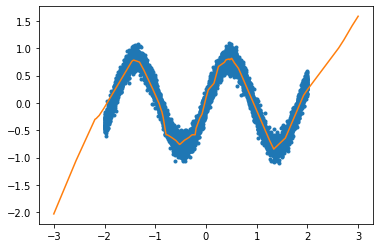

In [805]:
x_test=np.linspace(-3,3,1000).reshape(1000,1)
plt.plot(x,y,'.')
plt.plot(x_test,net.forward(x_test))
